#Inportacion de Librerias

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
from plotly.subplots import make_subplots

from scipy.stats import zscore

from collections import Counter
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from scipy.spatial.distance import euclidean

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE

from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/full-filled-brain-stroke-dataset/full_data.csv
/kaggle/input/full-filled-brain-stroke-dataset/full_filled_stroke_data (1).csv


# Lectura de datos

In [3]:
data_frame = pd.read_csv("/kaggle/input/full-filled-brain-stroke-dataset/full_data.csv")

In [3]:
print(data_frame.shape)
strokess = data_frame['stroke'] == 1
strokess = strokess[strokess]
print(len(strokess))
print(str(4981 - len(strokess)))

(4981, 11)
248
4733


# Exploracion de datos

In [9]:
data_explore = data_frame.copy()
data_explore.head(10)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
5,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
6,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
7,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1
8,Female,81.0,1,0,Yes,Private,Rural,80.43,29.7,never smoked,1
9,Female,61.0,0,1,Yes,Govt_job,Rural,120.46,36.8,smokes,1


In [10]:
data_explore.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000
mean,43.419859,0.096165,0.055210,105.943562,28.498173,0.049789
std,22.662755,0.294848,0.228412,45.075373,6.790464,0.217531
min,0.080000,0.000000,0.000000,55.120000,14.000000,0.000000
25%,25.000000,0.000000,0.000000,77.230000,23.700000,0.000000
50%,45.000000,0.000000,0.000000,91.850000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,113.860000,32.600000,0.000000
max,82.000000,1.000000,1.000000,271.740000,48.900000,1.000000


# Eliminacion de muestras con datos faltantes

In [4]:
#Lo primero que se observa es que en la columna de Smoking_status tenemos datos faltantes,
#al ser una caracteristica de tipo categórico tendremos que eliminar esas muestras.
#Se reemplaza el valor de Unknown por NaN
#Se eliminan las muestras que presentan datos faltantes
def eliminarDatosFaltantes(dta):
    dta['smoking_status'].replace(to_replace='Unknown', value=np.nan,inplace=True)
    return dta.dropna()

In [13]:
data_explore = eliminarDatosFaltantes(data_frame)
data_explore.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3481 entries, 0 to 4980
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             3481 non-null   object 
 1   age                3481 non-null   float64
 2   hypertension       3481 non-null   int64  
 3   heart_disease      3481 non-null   int64  
 4   ever_married       3481 non-null   object 
 5   work_type          3481 non-null   object 
 6   Residence_type     3481 non-null   object 
 7   avg_glucose_level  3481 non-null   float64
 8   bmi                3481 non-null   float64
 9   smoking_status     3481 non-null   object 
 10  stroke             3481 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 326.3+ KB


# Caracteristicas vs Stroke

In [15]:
#Stroke vs Gender
counts0 = Counter(data_explore[data_explore['stroke']==0]['gender'])
counts1 = Counter(data_explore[data_explore['stroke']==1]['gender'])
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "pie"}]])

fig.add_trace(go.Pie(
     values=[item[1] for item in sorted(counts0.items())],
     labels=[item[0] for item in sorted(counts0.items())],
     domain=dict(x=[0, 0.5]),
     name="Stroke Negativo",title='Stroke Negativo'), 
     row=1, col=1)

fig.add_trace(go.Pie(
     values=[item[1] for item in sorted(counts1.items())],
     labels=[item[0] for item in sorted(counts1.items())],
     domain=dict(x=[0.5, 1.0]),
     name="Stroke Positivo",title='Stroke Positivo'),
    row=1, col=2)

fig.update_layout(
    title={'text':'Stroke vs Gender','xanchor':'left','yanchor': 'top','y':0.9,'x':0.35},
    xaxis_title="X Axis Title",
    yaxis_title="Y Axis Title",
    legend_title="Gender",
    font=dict(size=18)
)

fig.show()

In [16]:
max_age = np.max(data_explore['age'])
print(max_age)

82.0


Text(0, 0.5, 'Count')

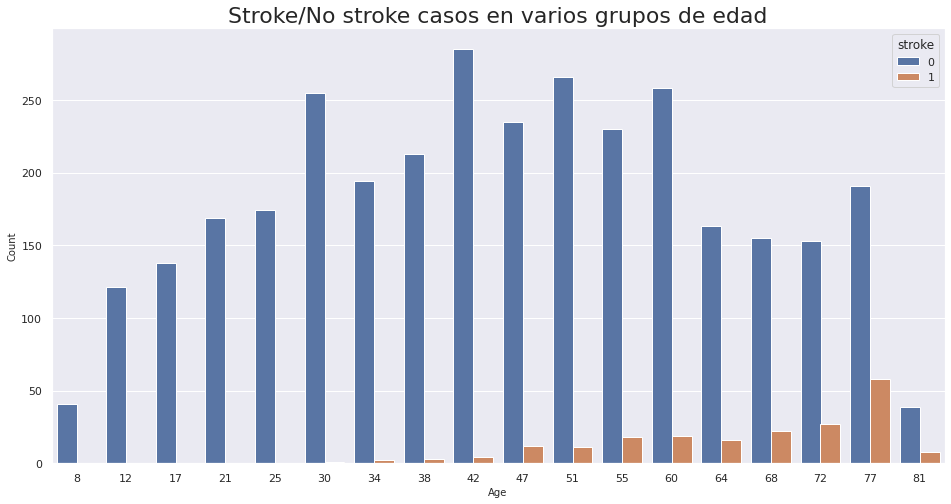

In [17]:
#Stoke vs Age
age_bins = np.linspace(0, 90, 22)
aux = data_explore.copy()
aux['binned_age'] = pd.cut(aux['age'], age_bins, labels=age_bins[:-1],right=False)
aux['binned_age'] = aux['binned_age'].astype('int')
sns.set(rc={'figure.figsize':(16,8)})
ax = sns.countplot(x='binned_age', hue='stroke', data=aux)
ax.set_title('Stroke/No stroke casos en varios grupos de edad').set_fontsize(22)
ax.set_xlabel('Age',fontsize=10)
ax.set_ylabel('Count',fontsize=10)

In [18]:
#Stroke vs Hypertension
counts0 = Counter(data_frame[data_frame['stroke']==0]['hypertension'])
counts1 = Counter(data_frame[data_frame['stroke']==1]['hypertension'])
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "pie"}]])

fig.add_trace(go.Pie(
     values=[item[1] for item in sorted(counts0.items())],
     labels=['No','Yes'],
     domain=dict(x=[0, 0.5]),
     name="Stroke Negative",title='Stroke Negative'), 
     row=1, col=1)

fig.add_trace(go.Pie(
     values=[item[1] for item in sorted(counts1.items())],
     labels=['No','Yes'],
     domain=dict(x=[0.5, 1.0]),
     name="Stroke Positive",title='Stroke Positive'),
    row=1, col=2)

fig.update_layout(
    title={'text':'Stroke vs Hypertension','xanchor':'left','yanchor': 'top','y':0.9,'x':0.35},
    xaxis_title="X Axis Title",
    yaxis_title="Y Axis Title",
    legend_title="Hypertension",
    font=dict(size=18)
)

fig.show()

In [19]:
#Stroke vs Heart Disease
counts0 = Counter(data_explore[data_explore['stroke']==0]['heart_disease'])
counts1 = Counter(data_explore[data_explore['stroke']==1]['heart_disease'])
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "pie"}]])

fig.add_trace(go.Pie(
     values=[item[1] for item in sorted(counts0.items())],
     labels=['No','Yes'],
     domain=dict(x=[0, 0.5]),
     name="Stroke Negative",title='Stroke Negative'), 
     row=1, col=1)

fig.add_trace(go.Pie(
     values=[item[1] for item in sorted(counts1.items())],
     labels=['No','Yes'],
     domain=dict(x=[0.5, 1.0]),
     name="Stroke Positive",title='Stroke Positive'),
    row=1, col=2)

fig.update_layout(
    title={'text':'Stroke vs Heart Disease','xanchor':'left','yanchor': 'top','y':0.9,'x':0.35},
    xaxis_title="X Axis Title",
    yaxis_title="Y Axis Title",
    legend_title="Heart Disease",
    font=dict(size=18)
)

fig.show()

In [20]:
#Stroke vs Ever Married
counts0 = Counter(data_explore[data_explore['stroke']==0]['ever_married'])
counts1 = Counter(data_explore[data_explore['stroke']==1]['ever_married'])
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "pie"}]])

fig.add_trace(go.Pie(
     values=[item[1] for item in sorted(counts0.items())],
     labels=[item[0] for item in sorted(counts0.items())],
     domain=dict(x=[0, 0.5]),
     name="Stroke Negative",title='Stroke Negative'), 
     row=1, col=1)

fig.add_trace(go.Pie(
     values=[item[1] for item in sorted(counts1.items())],
     labels=[item[0] for item in sorted(counts1.items())],
     domain=dict(x=[0.5, 1.0]),
     name="Stroke Positive",title='Stroke Positive'),
    row=1, col=2)

fig.update_layout(
    title={'text':'Stroke vs Marital Status','xanchor':'left','yanchor': 'top','y':0.9,'x':0.35},
    xaxis_title="X Axis Title",
    yaxis_title="Y Axis Title",
    legend_title="Ever Married?",
    font=dict(size=18)
)

fig.show()

In [21]:
#Stroke vs Worktype
counts0 = Counter(data_explore[data_explore['stroke']==0]['work_type'])
counts1 = Counter(data_explore[data_explore['stroke']==1]['work_type'])
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "pie"}]])

fig.add_trace(go.Pie(
     values=[item[1] for item in sorted(counts0.items())],
     labels=[item[0] for item in sorted(counts0.items())],
     domain=dict(x=[0, 0.5]),
     name="Stroke Negative",title='Stroke Negative'), 
     row=1, col=1)

fig.add_trace(go.Pie(
     values=[item[1] for item in sorted(counts1.items())],
     labels=[item[0] for item in sorted(counts1.items())],
     domain=dict(x=[0.5, 1.0]),
     name="Stroke Positive",title='Stroke Positive'),
    row=1, col=2)

fig.update_layout(
    title={'text':'Stroke vs Worktype','xanchor':'left','yanchor': 'top','y':0.9,'x':0.35},
    xaxis_title="X Axis Title",
    yaxis_title="Y Axis Title",
    legend_title="Worktype",
    font=dict(size=18)
)

fig.show()

In [22]:
#Stroke vs Residence Type
counts0 = Counter(data_explore[data_explore['Residence_type']=='Rural']['stroke'])
counts1 = Counter(data_explore[data_explore['Residence_type']=='Urban']['stroke'])
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "pie"}]])

fig.add_trace(go.Pie(
     values=[v for k,v in counts0.items()],
     labels=['Stroke Positive','Stroke Negative'],
     domain=dict(x=[0, 0.5]),
     name="Stroke Negative",title='Rural'), 
     row=1, col=1)

fig.add_trace(go.Pie(
     values=[v for k,v in counts1.items()],
     labels=['Stroke Positive','Stroke Negative'],
     domain=dict(x=[0.5, 1.0]),
     name="Stroke Positive",title='Urban'),
    row=1, col=2)

fig.update_layout(
    title={'text':'Residence Type vs Stroke','xanchor':'left','yanchor': 'top','y':0.9,'x':0.35},
    xaxis_title="X Axis Title",
    yaxis_title="Y Axis Title",
    legend_title="Stroke Status",
    font=dict(size=18)
)

fig.show()

In [23]:
max_glucose_level = np.max(data_explore['avg_glucose_level'])
print(max_glucose_level)

271.74


Text(0, 0.5, 'Count')

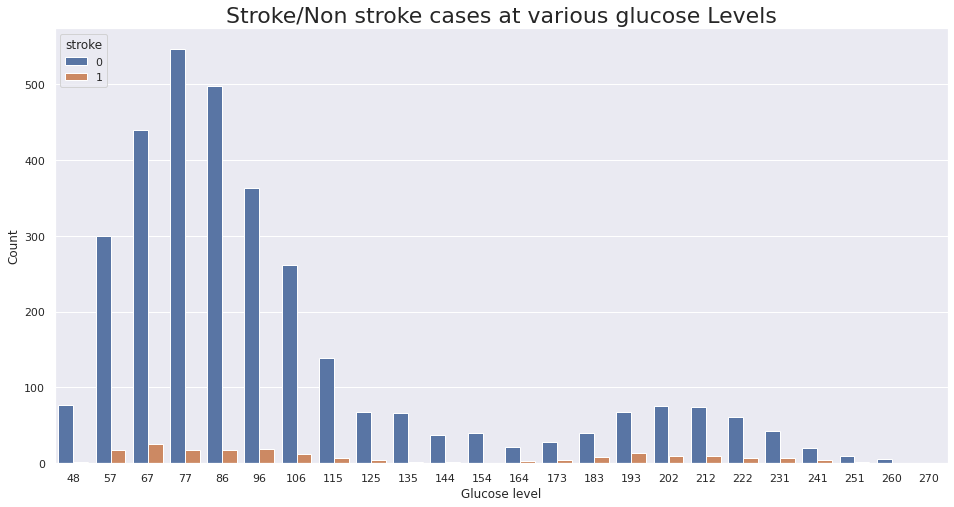

In [24]:
#Stroke vs Glucose Level
glucose_bins = np.linspace(0, 280, 30)
aux = data_explore.copy()
aux['binned_glucose'] = pd.cut(aux['avg_glucose_level'], glucose_bins, labels=glucose_bins[:-1],right=False)
aux['binned_glucose'] = aux['binned_glucose'].astype('int')

sns.set(rc={'figure.figsize':(16,8)})
ax = sns.countplot(x='binned_glucose',hue='stroke',data=aux)
ax.set_title('Stroke/Non stroke cases at various glucose Levels').set_fontsize(22)
ax.set_xlabel('Glucose level',fontsize=12)
ax.set_ylabel('Count',fontsize=12)

In [25]:
max_bmi = np.max(data_explore['bmi'])
print(max_bmi)

48.9


Text(0, 0.5, 'Count')

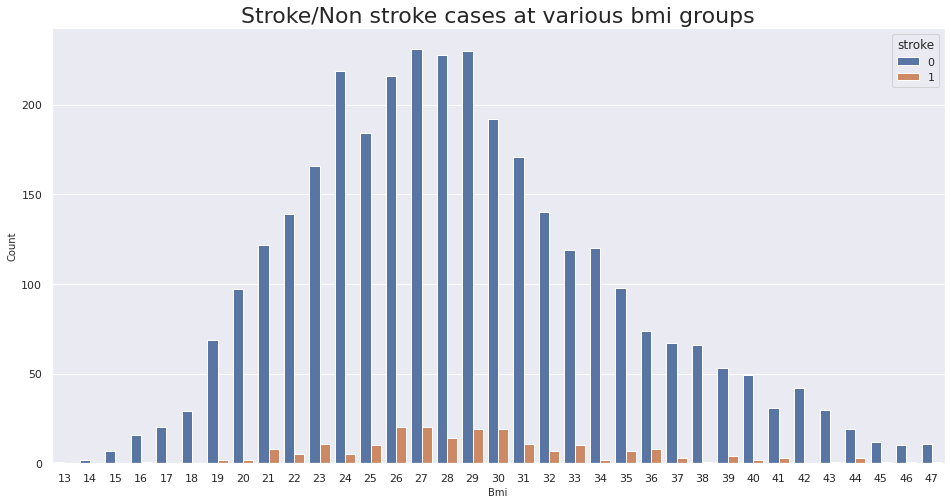

In [26]:
#Stroke vs BMI
bmi_bins = np.linspace(0, 50, 50)
aux = data_explore.copy()
aux['binned_bmi'] = pd.cut(aux['bmi'], bmi_bins, labels=bmi_bins[:-1],right=False)
aux['binned_bmi'] = aux['binned_bmi'].astype('int')

sns.set(rc={'figure.figsize':(16,8)})
ax = sns.countplot(x='binned_bmi', hue='stroke', data=aux)
ax.set_title('Stroke/Non stroke cases at various bmi groups').set_fontsize(22)
ax.set_xlabel('Bmi',fontsize=10)
ax.set_ylabel('Count',fontsize=10)

In [27]:
#Stroke vs Smoking Status

counts0 = Counter(data_explore[data_explore['stroke']==0]['smoking_status'])
counts1 = Counter(data_explore[data_explore['stroke']==1]['smoking_status'])
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "pie"}]])

fig.add_trace(go.Pie(
     values=[item[1] for item in sorted(counts0.items())],
     labels=[item[0] for item in sorted(counts0.items())],
     domain=dict(x=[0, 0.5]),
     name="Stroke Negative",title='Stroke Negative'), 
     row=1, col=1)

fig.add_trace(go.Pie(
     values=[item[1] for item in sorted(counts1.items())],
     labels=[item[0] for item in sorted(counts1.items())],
     domain=dict(x=[0.5, 1.0]),
     name="Stroke Positive",title='Stroke Positive'),
    row=1, col=2)

fig.update_layout(
    title={'text':'Stroke vs Smoking Status','xanchor':'left','yanchor': 'top','y':0.9,'x':0.35},
    xaxis_title="X Axis Title",
    yaxis_title="Y Axis Title",
    legend_title="Smoking Status",
    font=dict(size=18)
)

fig.show()

# Codificacion de datos categóricos

In [7]:
def codDatosCategoricos(dta):
    res = dta.copy()
    X =  dta[['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']]
    enc = OrdinalEncoder()
    enc.fit(X)
    categ = enc.categories_
    res[['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']] = enc.transform(X)
    return (res, categ)

# Clases

In [8]:
def dividirEnClases(dta):
    stroke = dta['stroke'] == 1
    df_stroke = dta.loc[stroke]
    no_stroke = dta['stroke'] == 0
    df_no_stroke = dta.loc[no_stroke]
    return (df_stroke, df_no_stroke)
    

# Grafica de cajas y bigotes

<AxesSubplot:>

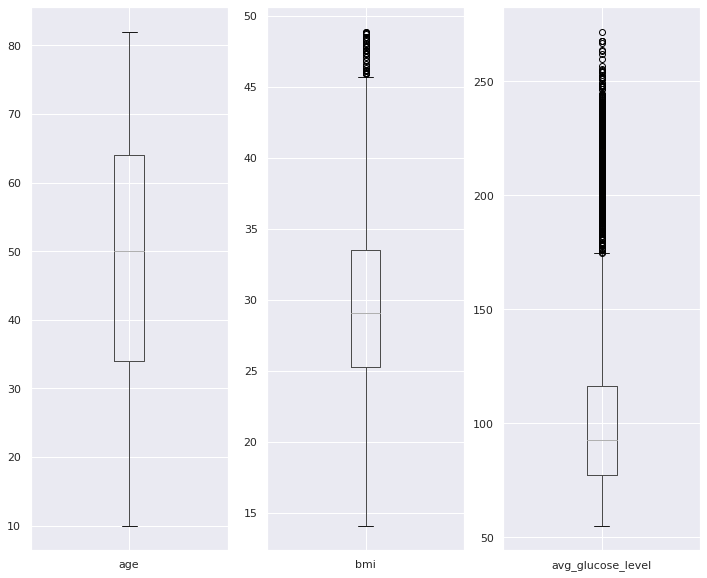

In [60]:
#Solo se realizará graficas de cajas y bigotes a las caracteristicas con valores de
#tipo continuo
data = data_frame.copy()
data = eliminarDatosFaltantes(data)
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12,10))
data.boxplot(ax=ax1, column=['age'], figsize=(4,10))
data.boxplot(ax=ax2, column=['bmi'], figsize=(4,10))
data.boxplot(ax=ax3, column=['avg_glucose_level'], figsize=(4,10))

# Tratamiento de datos atípicos usando zscore

In [61]:
# def delOutliersZscore(dta, columns, limite = None):
#     data_no_outliers = dta.copy()
    
#     z_scores = {}
#     for col in columns:
#         zscors = zscore(data_no_outliers[col])
#         zscors = np.abs(zscors)
#         lmit = limite
#         if limite == None:
#             lmit = np.std(zscors) * 3
#         z_scores[col] = [zscors, lmit]
            
#     aux = []
#     for col in columns:
#         zscor = z_scores[col][0]
#         limt = z_scores[col][1]
#         for x in aux:
#             zscor = zscor[x]
#         outliers = (zscor < limt)
#         data_no_outliers = data_no_outliers[outliers]
#         aux.append(outliers)
    
#     return data_no_outliers

# Tratamiento de datos atípicos usando quantiles

In [62]:
# def delOutliersQuiantiles(dta, columns):
#     data_no_outliers = dta.copy()
#     quantils = {}
#     for col in columns:
#         q1 = data_no_outliers[col].quantile(0.25)
#         q3 = data_no_outliers[col].quantile(0.75)
#         iqr = q3 - q1
#         bigote_inf = q1 - 1.5*iqr
#         bigote_sup = q3 + 1.5*iqr
#         quantils[col] = [bigote_inf, bigote_sup]
    
#     for col in columns:
#         bigote_inf = quantils[col][0]
#         bigote_sup = quantils[col][1]
#         outliers = (data_no_outliers[col] >= bigote_inf) & (data_no_outliers[col] <= bigote_sup)
#         data_no_outliers = data_no_outliers[outliers]
    
#     return data_no_outliers

# Funciones

In [9]:
def delColumns(df, columnas):
    col_names = df.columns.values
    col_names_list = list(col_names)
    for col in columnas:
        col_names_list.remove(col)
    return df[col_names_list]

In [10]:
def getXandY(dta):
    nfeatures = dta.shape[1]
    return (dta.iloc[:, 0:(nfeatures-1)], dta['stroke'])

In [11]:
def split_data(X, Y, test_sze):
    return train_test_split(X, Y, test_size=test_sze, random_state=10)

In [12]:
def normalizar_data(xtrain, xtest):
    scaler = StandardScaler()
    scaler.fit(xtrain)
    return (scaler.transform(X = xtrain), scaler.transform(X = xtest))

In [13]:
def normalizar_data(X):
    scaler = StandardScaler()
    scaler.fit(X)
    return scaler.transform(X)

# Balanceo de datos

In [14]:
def balancerDatos(X, Y):
    sm = SMOTE(random_state=10)
    return sm.fit_resample(X, Y)

# Experimentos

# Analisis de discriminante cuadratico

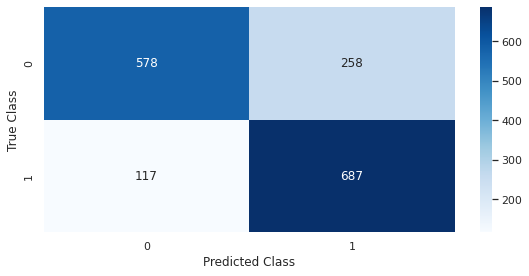

              precision    recall  f1-score   support

           0       0.83      0.69      0.76       836
           1       0.73      0.85      0.79       804

    accuracy                           0.77      1640
   macro avg       0.78      0.77      0.77      1640
weighted avg       0.78      0.77      0.77      1640



In [67]:
data = data_frame.copy()
data = eliminarDatosFaltantes(data)
data, _ = codDatosCategoricos(data)
X, Y = getXandY(data)
X, Y = balancerDatos(X, Y)
X_train, X_test, Y_train, Y_test = split_data(X, Y, 0.25)
Xtrain, Xtest = normalizar_data(X_train, X_test)
QDA = QuadraticDiscriminantAnalysis()
QDA.fit(X=Xtrain, y=Y_train)
Yest = QDA.predict(X=Xtest)
matrix = confusion_matrix(Y_test, Yest)
fig, aux = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=aux)
aux.set_xlabel("Predicted Class")
aux.set_ylabel("True Class")
fig.tight_layout()
plt.show()
print(classification_report(Y_test, Yest))

# Experimentar

In [66]:
def experimentar_adc(X, Y, folds):
    resultados = pd.DataFrame()
    idx = 0
    for fold in folds:
        skf = StratifiedKFold(n_splits=fold)
        EficienciaTrain = []
        EficienciaVal = []
        RecallTrain = []
        RecallTest = []
        for train, test in skf.split(X, Y):
            Xtrain = X[train,:]
            Ytrain = Y.iloc[train]
            Xtest = X[test,:]
            Ytest = Y.iloc[test]
            #Haga el llamado a la función para crear y entrenar el modelo
            #usando los datos de entrenamiento
            modelo = QuadraticDiscriminantAnalysis()
            modelo.fit(X=Xtrain, y=Ytrain)
            #predecir muestras de entrenamiento
            Ytrain_pred = modelo.predict(X=Xtrain)
            #predecir muestras de pruebas
            Ytest_pred = modelo.predict(X=Xtest)
            #Evaluamos las predicciones del modelo con los datos de test
            EficienciaTrain.append(np.mean(Ytrain_pred.ravel() == Ytrain.ravel()))
            EficienciaVal.append(np.mean(Ytest_pred.ravel() == Ytest.ravel()))
            RecallTrain.append(recall_score(Ytrain,Ytrain_pred))
            RecallTest.append(recall_score(Ytest, Ytest_pred))

        resultados.loc[idx,'número de folds'] = fold
        resultados.loc[idx,'eficiencia de entrenamiento'] = np.mean(EficienciaTrain)
        resultados.loc[idx,'std entrenamiento'] = np.std(EficienciaTrain)
        resultados.loc[idx,'eficiencia de prueba'] =np.mean(EficienciaVal)
        resultados.loc[idx,'std prueba'] = np.std(EficienciaVal)
        resultados.loc[idx,'media recall train'] = np.mean(RecallTrain)
        resultados.loc[idx,'std recall train'] = np.std(RecallTrain)
        resultados.loc[idx,'media recall test'] = np.mean(RecallTest)
        resultados.loc[idx,'std recall test'] = np.std(RecallTest)
        idx= idx +1
        
    return (resultados)

In [67]:
data = data_frame.copy()
data = eliminarDatosFaltantes(data)
data, _ = codDatosCategoricos(data)
X, Y = getXandY(data)
X, Y = balancerDatos(X, Y)
X = normalizar_data(X)
folds=[3,4,5,7,9]
exp_adc = experimentar_adc(X, Y, folds)
exp_adc

,número de folds,eficiencia de entrenamiento,std entrenamiento,eficiencia de prueba,std prueba,media recall train,std recall train,media recall test,std recall test
0,3.0,0.777058,0.007166,0.766311,0.012335,0.857774,0.003187,0.844832,0.035507
1,4.0,0.777033,0.005490,0.770579,0.011329,0.856402,0.002139,0.846951,0.032132
2,5.0,0.776867,0.004350,0.769665,0.019494,0.856326,0.003757,0.846951,0.048557
3,7.0,0.777490,0.003998,0.769064,0.026513,0.857673,0.004400,0.846659,0.060974
4,9.0,0.777172,0.003626,0.770276,0.029823,0.857279,0.004351,0.849724,0.065269


# Ventana de parzen

In [42]:
def kernel_gaussiano(x):
    return np.exp((-0.5)*x**2)

In [43]:
def ParzenWindow(h,x,Data):
    h = h
    Ns = Data.shape[0]
    suma = 0
    for k in range(Ns):
        u = euclidean(x, Data[k,:])
        suma += kernel_gaussiano(u/h)
    return suma

In [44]:
def parzenClass(h, xtrain, ytrain, xtest):
    Yest = np.zeros(xtest.shape[0])
    clases = np.unique(ytrain)
    fds_matrix = np.zeros((xtest.shape[0], len(clases)))
    
    for n, sample in enumerate (xtest):
        ax = np.zeros(len(clases))
        for label in clases:
            index = np.where(ytrain == label)
            train = xtrain[index]
            N = len(train)
            ax[label] = ParzenWindow(h, sample, train)/N
        
        fds_matrix[n] = ax
        Yest[n] = np.argmax(ax)

    return Yest, fds_matrix

In [45]:
def experimentarParzen (hs, xtrain, ytrain, xtest):
    resultados = {}
    idx = 0
    # iteramos sobre los valores de hs
    for h in hs:
        Yest, _ = parzenClass(h, xtrain, ytrain, xtest)    
        resultados[h] = Yest
        idx+=1
    return (resultados)

In [105]:
hs = [0.5, 5, 10, 50]
data = data_frame.copy()
data = eliminarDatosFaltantes(data)
data, _ = codDatosCategoricos(data)
X, Y = getXandY(data)
X, Y = balancerDatos(X, Y)
X_train, X_test, Y_train, Y_test = split_data(X, Y, 0.25)
Xtrain, Xtest = normalizar_data(X_train, X_test)
exp_parzen = experimentarParzen(hs, Xtrain, Y_train, Xtest)

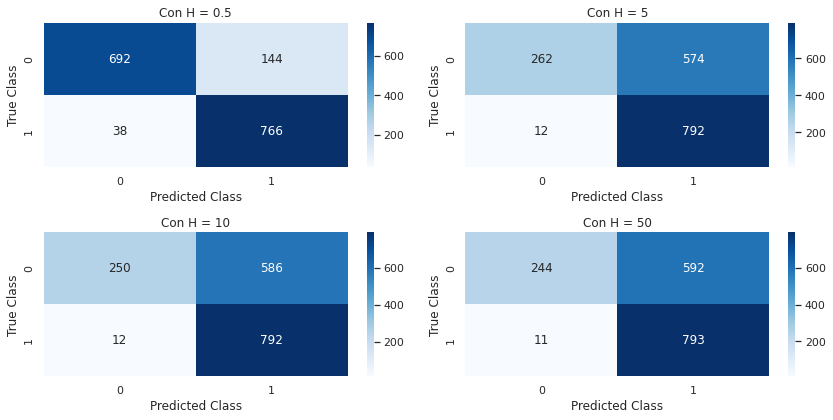

Con H:  0.5
              precision    recall  f1-score   support

           0       0.95      0.83      0.88       836
           1       0.84      0.95      0.89       804

    accuracy                           0.89      1640
   macro avg       0.89      0.89      0.89      1640
weighted avg       0.90      0.89      0.89      1640

Con H:  5
              precision    recall  f1-score   support

           0       0.96      0.31      0.47       836
           1       0.58      0.99      0.73       804

    accuracy                           0.64      1640
   macro avg       0.77      0.65      0.60      1640
weighted avg       0.77      0.64      0.60      1640

Con H:  10
              precision    recall  f1-score   support

           0       0.95      0.30      0.46       836
           1       0.57      0.99      0.73       804

    accuracy                           0.64      1640
   macro avg       0.76      0.64      0.59      1640
weighted avg       0.77      0.64      0.

,H,Accuracy,Recall,Precision,F1
0,0.5,0.889024,0.952736,0.841758,0.893816
1,5.0,0.642683,0.985075,0.579795,0.729954
2,10.0,0.635366,0.985075,0.574746,0.725940
3,50.0,0.632317,0.986318,0.572563,0.724532


In [106]:
rows = len(hs)//2
if len(hs) % 2 != 0:
    rows += 1
fig, axs = plt.subplots(nrows=rows, ncols=2, figsize=(12, rows*3))
if rows > 1:
    fil = 0
    col = 0
    for key in exp_parzen:
        matrix = confusion_matrix(Y_test, exp_parzen[key])
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=axs[fil, col])
        axs[fil, col].set_title("Con H = " + str(key))
        axs[fil, col].set_xlabel("Predicted Class")
        axs[fil, col].set_ylabel("True Class")
        if col == 1:
            col = 0
            fil += 1
        else:
            col += 1
else:
    i = 0
    for key in exp_parzen:
        matrix = confusion_matrix(Y_test, exp_parzen[key])
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=axs[i])
        axs[i].set_title("Con H = " + str(key))
        axs[i].set_xlabel("Predicted Class")
        axs[i].set_ylabel("True Class")
        i += 1
    
fig.tight_layout()
plt.show()

metricas = pd.DataFrame()
i = 0
for key in exp_parzen:
    metricas.loc[i, 'H'] = key
    metricas.loc[i, "Accuracy"] = accuracy_score(Y_test, exp_parzen[key])
    metricas.loc[i, "Recall"] = recall_score(Y_test, exp_parzen[key])
    metricas.loc[i, "Precision"] = precision_score(Y_test, exp_parzen[key])
    metricas.loc[i, "F1"] = f1_score(Y_test, exp_parzen[key])
    i += 1
    print("Con H: ", key)
    print(classification_report(Y_test, exp_parzen[key]))
metricas

# Experimentar

In [40]:
def experimentar_vp(hs, X, Y, folds):
    skf = StratifiedKFold(n_splits=folds)
    resultados = pd.DataFrame()
    idx = 0
    for h in hs:
        ## para almacenar los errores intermedios
        EficienciaTrain = []
        EficienciaVal = []
        RecallTrain = []
        RecallTest = []
        for train, test in skf.split(X, Y):
            Xtrain = X[train,:]
            Ytrain = Y.iloc[train]
            Xtest = X[test,:]
            Ytest = Y.iloc[test]
            #Haga el llamado a la función para crear y entrenar el modelo
            #usando los datos de entrenamiento
            #predecir muestras de entrenamiento
            Ytrain_pred, _ = parzenClass(h, Xtrain, Ytrain, Xtrain)
            #predecir muestras de pruebas
            Ytest_pred, _ = parzenClass(h, Xtrain, Ytrain, Xtest)
            #Evaluamos las predicciones del modelo con los datos de test
            EficienciaTrain.append(np.mean(Ytrain_pred.ravel() == Ytrain.ravel()))
            EficienciaVal.append(np.mean(Ytest_pred.ravel() == Ytest.ravel()))
            RecallTrain.append(recall_score(Ytrain,Ytrain_pred))
            RecallTest.append(recall_score(Ytest, Ytest_pred))

        resultados.loc[idx,'H'] = h
        resultados.loc[idx,'eficiencia de entrenamiento'] = np.mean(EficienciaTrain)
        resultados.loc[idx,'std entrenamiento'] = np.std(EficienciaTrain)
        resultados.loc[idx,'eficiencia de prueba'] =np.mean(EficienciaVal)
        resultados.loc[idx,'std prueba'] = np.std(EficienciaVal)
        resultados.loc[idx,'media recall train'] = np.mean(RecallTrain)
        resultados.loc[idx,'std recall train'] = np.std(RecallTrain)
        resultados.loc[idx,'media recall test'] = np.mean(RecallTest)
        resultados.loc[idx,'std recall test'] = np.std(RecallTest)
        idx= idx +1
        
    return (resultados)

In [46]:
hs = [0.5, 5, 20]
data = data_frame.copy()
data = eliminarDatosFaltantes(data)
data, _ = codDatosCategoricos(data)
X, Y = getXandY(data)
X, Y = balancerDatos(X, Y)
X = normalizar_data(X)
exp_parz = experimentar_vp(hs, X, Y, 3)
exp_parz

,H,eficiencia de entrenamiento,std entrenamiento,eficiencia de prueba,std prueba,media recall train,std recall train,media recall test,std recall test
0,0.5,0.943521,0.001219,0.888415,0.005600,0.976525,0.003774,0.953666,0.019168
1,5.0,0.659832,0.014768,0.663416,0.011692,0.978508,0.007838,0.978657,0.003457
2,20.0,0.652591,0.018142,0.655947,0.012790,0.980032,0.008465,0.980790,0.005234


# PCA

In [57]:
def pca_ext_caract_vp(n_comp, n_sets, X, Y, h):
    RecallTest = np.ones(n_sets)
    RecallTrain = np.ones(n_sets)
    EficienciaTest = np.ones(n_sets)
    EficienciaTrain = np.ones(n_sets)
    j = 0
    skf = StratifiedKFold(n_splits=n_sets)
    for train, test in skf.split(X, Y):
        X_train = X[train,:]
        y_train = Y.iloc[train]
        X_test = X[test,:]
        y_test = Y.iloc[test]
        pca = PCA(n_components=n_comp)
        X_train = pca.fit_transform(X_train)
        X_test = pca.fit_transform(X_test)
        
        y_pred_test, _ = parzenClass(h, X_train, y_train, X_test)
        y_pred_train, _ = parzenClass(h, X_train, y_train, X_train)
        
        RecallTest[j] = recall_score(y_true=y_test, y_pred=y_pred_test)
        RecallTrain[j] = recall_score(y_true=y_train, y_pred=y_pred_train)
        EficienciaTest[j] = (np.mean(y_pred_test.ravel() == y_test.ravel()))
        EficienciaTrain[j] = (np.mean(y_pred_train.ravel() == y_train.ravel()))
        j+=1
        
    return EficienciaTrain, EficienciaTest, RecallTrain, RecallTest

In [60]:
def experimentar_PCA_vp(n_feats, X, Y, hs, n_split):
    df = pd.DataFrame()
    idx = 0
    for h in hs:
        for f in n_feats:
            EficienciaTrain, EficienciaTest, RecallTrain, RecallTest = pca_ext_caract_vp(f, n_split, X, Y, h)
            print(h, f)
            df.loc[idx,'num_var'] = f
            df.loc[idx,'h'] = h
            df.loc[idx,'eficiencia train'] = np.mean(EficienciaTrain)
            df.loc[idx,'std train'] = np.std(EficienciaTrain)
            df.loc[idx,'eficiencia test'] = np.mean(EficienciaTest)
            df.loc[idx,'std test'] = np.std(EficienciaTest)
            df.loc[idx,'mean recall train'] = np.mean(RecallTrain)
            df.loc[idx,'std recall train'] = np.std(RecallTrain)
            df.loc[idx,'mean recall test'] = np.mean(RecallTest)
            df.loc[idx,'std recall test'] = np.std(RecallTest)
            idx+=1
    return df

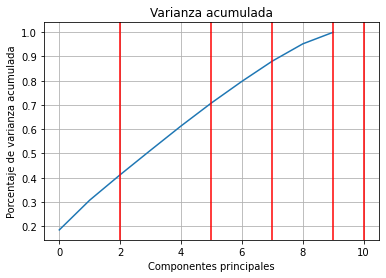

In [64]:
data = data_frame.copy()
data = eliminarDatosFaltantes(data)
data, _ = codDatosCategoricos(data)
X, Y = getXandY(data)
X, Y = balancerDatos(X, Y)
X = normalizar_data(X)
pca = PCA(n_components=X.shape[1])
pca_varianza = pca.fit(X)
plt.plot(np.cumsum(pca_varianza.explained_variance_/np.sum(pca_varianza.explained_variance_)))
plt.axvline(x=2, c= 'r')
plt.axvline(x=5, c= 'r')
plt.axvline(x=7, c= 'r')
plt.axvline(x=9, c= 'r')
plt.axvline(x=10, c= 'r')
plt.title('Varianza acumulada')
plt.xlabel('Componentes principales')
plt.ylabel('Porcentaje de varianza acumulada')
plt.grid()

In [61]:
hs = [20]
data = data_frame.copy()
data = eliminarDatosFaltantes(data)
data, _ = codDatosCategoricos(data)
X, Y = getXandY(data)
X, Y = balancerDatos(X, Y)
X = normalizar_data(X)
nfeats = [7,8,9]
exp_parz = experimentar_PCA_vp(nfeats, X, Y, hs, 3)
exp_parz

20 5
20 7
20 9


,num_var,h,eficiencia train,std train,eficiencia test,std test,mean recall train,std recall train,mean recall test,std recall test
0,5.0,20.0,0.666920,0.010587,0.507455,0.123632,0.933998,0.019514,0.758854,0.131547
1,7.0,20.0,0.638414,0.011240,0.507762,0.103307,0.964179,0.010792,0.818606,0.113302
2,9.0,20.0,0.635747,0.014064,0.513558,0.098898,0.971496,0.009834,0.832334,0.097820


# Gradiente Boosting Tree

In [74]:
def experimentar_gbt(num_trees, X, Y, folds):
    skf = StratifiedKFold(n_splits=folds)
    resultados = pd.DataFrame()
    idx = 0
    for trees in num_trees:
        ## para almacenar los errores intermedios
        EficienciaTrain = []
        EficienciaVal = []
        RecallTrain = []
        RecallTest = []
        for train, test in skf.split(X, Y):
            Xtrain = X[train,:]
            Ytrain = Y.iloc[train]
            Xtest = X[test,:]
            Ytest = Y.iloc[test]
            #Haga el llamado a la función para crear y entrenar el modelo
            #usando los datos de entrenamiento
            modelo = GradientBoostingClassifier(loss= 'deviance',n_estimators = trees,min_samples_split=3)
            modelo.fit(X=Xtrain, y=Ytrain)
            #predecir muestras de entrenamiento
            Ytrain_pred = modelo.predict(X=Xtrain)
            #predecir muestras de pruebas
            Ytest_pred = modelo.predict(X=Xtest)
            #Evaluamos las predicciones del modelo con los datos de test
            EficienciaTrain.append(np.mean(Ytrain_pred.ravel() == Ytrain.ravel()))
            EficienciaVal.append(np.mean(Ytest_pred.ravel() == Ytest.ravel()))
            RecallTrain.append(recall_score(Ytrain,Ytrain_pred))
            RecallTest.append(recall_score(Ytest, Ytest_pred))

        resultados.loc[idx,'número de arboles'] = trees
        resultados.loc[idx,'eficiencia de entrenamiento'] = np.mean(EficienciaTrain)
        resultados.loc[idx,'std entrenamiento'] = np.std(EficienciaTrain)
        resultados.loc[idx,'eficiencia de prueba'] =np.mean(EficienciaVal)
        resultados.loc[idx,'std prueba'] = np.std(EficienciaVal)
        resultados.loc[idx,'media recall train'] = np.mean(RecallTrain)
        resultados.loc[idx,'std recall train'] = np.std(RecallTrain)
        resultados.loc[idx,'media recall test'] = np.mean(RecallTest)
        resultados.loc[idx,'std recall test'] = np.std(RecallTest)
        idx= idx +1
        
    return (resultados)

In [75]:
data = data_frame.copy()
data = eliminarDatosFaltantes(data)
data, _ = codDatosCategoricos(data)
X, Y = getXandY(data)
X, Y = balancerDatos(X, Y)
X = normalizar_data(X)
num_arb = [5, 20, 50, 100, 150]
nfolds = 5
exp_gbt = experimentar_gbt(num_arb, X, Y, nfolds)
exp_gbt

,número de arboles,eficiencia de entrenamiento,std entrenamiento,eficiencia de prueba,std prueba,media recall train,std recall train,media recall test,std recall test
0,5.0,0.809566,0.012516,0.803049,0.014092,0.863720,0.017166,0.858537,0.032069
1,20.0,0.907279,0.014133,0.894665,0.031718,0.915701,0.013266,0.899695,0.077330
2,50.0,0.952896,0.012316,0.941463,0.054058,0.925610,0.015250,0.911585,0.120675
3,100.0,0.962309,0.012187,0.952744,0.057247,0.930716,0.021371,0.917683,0.120606
4,150.0,0.965777,0.012543,0.955030,0.057298,0.936357,0.022691,0.921646,0.118791


# PCA

In [18]:
def pca_ext_caract_gbt(n_comp, n_sets, X, Y, trees):
    RecallTest = np.ones(n_sets)
    RecallTrain = np.ones(n_sets)
    EficienciaTest = np.ones(n_sets)
    EficienciaTrain = np.ones(n_sets)
    j = 0
    skf = StratifiedKFold(n_splits=n_sets)
    for train, test in skf.split(X, Y):
        X_train = X.iloc[train,:]
        y_train = Y.iloc[train]
        X_test = X.iloc[test,:]
        y_test = Y.iloc[test]
        pca = PCA(n_components=n_comp)
        # definimos un clasificador.
        clf = GradientBoostingClassifier(loss= 'deviance',n_estimators= trees,min_samples_split=3)
        definicion_pipeline = [
           ('scaler', StandardScaler()), ('pca', pca), ('qda', clf)
        ]
        pipeline = Pipeline(definicion_pipeline)
        pipeline.fit(X=X_train, y=y_train)
        y_pred_test=pipeline.predict(X_test)
        y_pred_train=pipeline.predict(X_train)
        RecallTest[j] = recall_score(y_true=y_test, y_pred=y_pred_test)
        RecallTrain[j] = recall_score(y_true=y_train, y_pred=y_pred_train)
        EficienciaTest[j] = (np.mean(y_pred_test.ravel() == y_test.ravel()))
        EficienciaTrain[j] = (np.mean(y_pred_train.ravel() == y_train.ravel()))
        j+=1
        
    return EficienciaTrain, EficienciaTest, RecallTrain, RecallTest

In [19]:
def experimentar_PCA_gbt(n_feats, X, Y, num_trees, n_split):
    df = pd.DataFrame()
    idx = 0
    for trees in num_trees:
        for f in n_feats:
            EficienciaTrain, EficienciaTest, RecallTrain, RecallTest = pca_ext_caract_gbt(f, n_split, X, Y, trees)
            df.loc[idx,'num_var'] = f
            df.loc[idx,'num de arboles'] = trees
            df.loc[idx,'eficiencia train'] = np.mean(EficienciaTrain)
            df.loc[idx,'std train'] = np.std(EficienciaTrain)
            df.loc[idx,'eficiencia test'] = np.mean(EficienciaTest)
            df.loc[idx,'std test'] = np.std(EficienciaTest)
            df.loc[idx,'mean recall train'] = np.mean(RecallTrain)
            df.loc[idx,'std recall train'] = np.std(RecallTrain)
            df.loc[idx,'mean recall test'] = np.mean(RecallTest)
            df.loc[idx,'std recall test'] = np.std(RecallTest)
            idx+=1
    return df

In [20]:
data = data_frame.copy()
data = eliminarDatosFaltantes(data)
data, _ = codDatosCategoricos(data)
X, Y = getXandY(data)
X, Y = balancerDatos(X, Y)
num_arb = [5, 50, 100]
nfolds = 5
n_caract = [7,8,9]
exp_gbt_pca = experimentar_PCA_gbt(n_caract, X, Y, num_arb, nfolds)
exp_gbt_pca

,num_var,num de arboles,eficiencia train,std train,eficiencia test,std test,mean recall train,std recall train,mean recall test,std recall test
0,3.0,5.0,0.703468,0.004645,0.687043,0.009167,0.764177,0.032988,0.741463,0.047805
1,5.0,5.0,0.710671,0.008431,0.698171,0.005805,0.843826,0.051050,0.828659,0.048442
2,7.0,5.0,0.713872,0.006416,0.701524,0.008496,0.845579,0.045856,0.833232,0.039193
3,9.0,5.0,0.736623,0.004304,0.728963,0.009355,0.847713,0.022327,0.841159,0.032458
4,3.0,50.0,0.733918,0.005732,0.709909,0.007176,0.809451,0.011387,0.785366,0.019697
5,5.0,50.0,0.795770,0.004107,0.767683,0.011880,0.854116,0.009308,0.830183,0.027869
6,7.0,50.0,0.807203,0.003500,0.777439,0.017481,0.856250,0.008668,0.829268,0.034681
7,9.0,50.0,0.807965,0.006701,0.782470,0.013408,0.856479,0.006764,0.832012,0.041236
8,3.0,100.0,0.747752,0.006239,0.713415,0.010605,0.818369,0.011185,0.782317,0.024341
9,5.0,100.0,0.826181,0.006250,0.787805,0.015430,0.865015,0.008260,0.831402,0.038354


# Redes Neuronales Artifiales

In [69]:
def experimetar_mlpc(X,Y, num_hidden_layers, num_neurons):
    Folds = 5
    skf = StratifiedKFold(n_splits=Folds)
    resultados = pd.DataFrame()
    idx = 0
    for hidden_layers in num_hidden_layers:
        for neurons in num_neurons:
            RecallTest = []
            for j, (train, test) in enumerate(skf.split(X=X, y=Y)):
                # para almacenar errores intermedios
                Error = np.zeros(Folds)
                Xtrain= X[train,:]
                Ytrain = Y.iloc[train]
                Xtest = X[test,:]
                Ytest = Y.iloc[test]
                #Normalizamos los datos
                scaler = StandardScaler().fit(X=Xtrain)       
                Xtrain = scaler.transform(Xtrain)
                Xtest = scaler.transform(Xtest)
                #Haga el llamado a la función para crear y entrenar el modelo usando los datos de entrenamiento
                # prestar atención a los parametros, correctos.
                hidden_layer_sizes = tuple(hidden_layers*[neurons])
                mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation='tanh', max_iter=5000, random_state = 1)
                # entrenar el MLP
                mlp.fit(X=Xtrain, y=Ytrain)
                #Use para el modelo para hacer predicciones sobre el conjunto Xtest
                Yest = mlp.predict(X = Xtest)
                # recordar usar la medida adecuada de acuerdo a las instrucciones
                Error[j] = 1-recall_score(y_true = Ytest,  y_pred = Yest)
                RecallTest.append(recall_score(Ytest, Yest))
                        
            resultados.loc[idx,'capas ocultas'] = hidden_layers
            resultados.loc[idx,'neuronas en capas ocultas'] = neurons 
            resultados.loc[idx,'error de prueba(media)'] = np.mean(Error)
            resultados.loc[idx,'intervalo de confianza'] = np.std(Error)
            resultados.loc[idx,'media recall test'] = np.mean(RecallTest)
            resultados.loc[idx,'std recall test'] = np.std(RecallTest)
            idx+=1
    return (resultados)

In [76]:
data = data_frame.copy()
data = eliminarDatosFaltantes(data)
data, _ = codDatosCategoricos(data)
X, Y = getXandY(data)
X, Y = balancerDatos(X, Y)
X = normalizar_data(X)
hidden_layers=[1,2]
num_neurons=[4,7,10]
exp_mlp = experimetar_mlpc(X, Y, hidden_layers, num_neurons)
exp_mlp

,capas ocultas,neuronas en capas ocultas,error de prueba(media),intervalo de confianza,media recall test,std recall test
0,1.0,4.0,0.027439,0.054878,0.824695,0.051542
1,1.0,7.0,0.025305,0.050610,0.843902,0.055815
2,1.0,10.0,0.024390,0.048780,0.842378,0.077816
3,2.0,4.0,0.028963,0.057927,0.825000,0.089970
4,2.0,7.0,0.025915,0.051829,0.842988,0.072044
5,2.0,10.0,0.022866,0.045732,0.858232,0.082311


# Maquinas de soporte vectorial

In [79]:
def best_parameters_svc(parameters, xtrain, ytrain):
    metrica = make_scorer(f1_score, greater_is_better=True)
    grid_svc = GridSearchCV(SVC(), parameters, scoring=metrica, cv=5)
    grid_svc.fit(xtrain, ytrain)
    return grid_svc.best_params_

In [141]:
data = data_frame.copy()
data = eliminarDatosFaltantes(data)
data, _ = codDatosCategoricos(data)
X, Y = getXandY(data)
X, Y = balancerDatos(X, Y)
X_train, X_test, Y_train, Y_test = split_data(X, Y, 0.25)
Xtrain, Xtest = normalizar_data(X_train, X_test)

In [143]:
parameters = { 'C': [0.1, 1, 10, 50, 100],
             'kernel': ['rbf','linear', 'poly', 'sigmoid'],
             'gamma': ['scale', 'auto']}
best_parameters = best_parameters_svc(parameters, Xtrain, Y_train)

print(best_parameters)

{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}


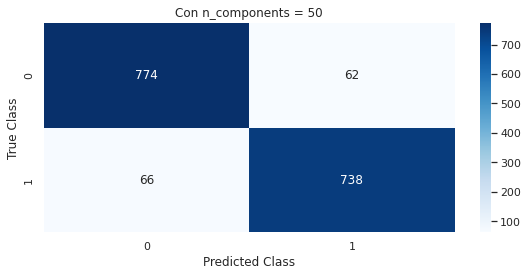

              precision    recall  f1-score   support

           0       0.92      0.93      0.92       836
           1       0.92      0.92      0.92       804

    accuracy                           0.92      1640
   macro avg       0.92      0.92      0.92      1640
weighted avg       0.92      0.92      0.92      1640

      H  Accuracy   Recall  Precision      F1
0  50.0  0.921951  0.91791     0.9225  0.9202


In [145]:
modSVC = SVC(C=100, gamma='scale', kernel='rbf')
modSVC.fit(Xtrain, Y_train)
Yest = modSVC.predict(Xtest)
matrix = confusion_matrix(Y_test, Yest)
fig, aux = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=aux)
aux.set_title("Con n_components = " + str(key))
aux.set_xlabel("Predicted Class")
aux.set_ylabel("True Class")
fig.tight_layout()
plt.show()
print(classification_report(Y_test, Yest))
metricas = pd.DataFrame()
metricas.loc[0, 'H'] = key
metricas.loc[0, "Accuracy"] = accuracy_score(Y_test, Yest)
metricas.loc[0, "Recall"] = recall_score(Y_test, Yest)
metricas.loc[0, "Precision"] = precision_score(Y_test, Yest)
metricas.loc[0, "F1"] = f1_score(Y_test, Yest)
print(metricas)

In [88]:
def experimentar_svc(X, Y, folds, params = None):
    resultados = pd.DataFrame()
    idx = 0
    for fold in folds:
        skf = StratifiedKFold(n_splits=fold)
        EficienciaTrain = []
        EficienciaVal = []
        RecallTrain = []
        RecallTest = []
        print(fold)
        for train, test in skf.split(X, Y):
            Xtrain = X[train,:]
            Ytrain = Y.iloc[train]
            Xtest = X[test,:]
            Ytest = Y.iloc[test]
            #Haga el llamado a la función para crear y entrenar el modelo
            #usando los datos de entrenamiento
            best_para = params
            if best_para == None:
                parameters = { 'C': [0.1, 1, 10, 50, 100],
                 'kernel': ['rbf','linear', 'poly', 'sigmoid'],
                 'gamma': ['scale', 'auto']}
                best_para = best_parameters_svc(parameters, Xtrain, Ytrain)
            print(best_para)
            modelo = SVC(C=best_para['C'], gamma=best_para['gamma'], kernel=best_para['kernel'])
            modelo.fit(Xtrain, Ytrain)
            #predecir muestras de entrenamiento
            Ytrain_pred = modelo.predict(X=Xtrain)
            #predecir muestras de pruebas
            Ytest_pred = modelo.predict(X=Xtest)
            #Evaluamos las predicciones del modelo con los datos de test
            EficienciaTrain.append(np.mean(Ytrain_pred.ravel() == Ytrain.ravel()))
            EficienciaVal.append(np.mean(Ytest_pred.ravel() == Ytest.ravel()))
            RecallTrain.append(recall_score(Ytrain,Ytrain_pred))
            RecallTest.append(recall_score(Ytest, Ytest_pred))

        resultados.loc[idx,'número de folds'] = fold
        resultados.loc[idx,'eficiencia de entrenamiento'] = np.mean(EficienciaTrain)
        resultados.loc[idx,'std entrenamiento'] = np.std(EficienciaTrain)
        resultados.loc[idx,'eficiencia de prueba'] =np.mean(EficienciaVal)
        resultados.loc[idx,'std prueba'] = np.std(EficienciaVal)
        resultados.loc[idx,'media recall train'] = np.mean(RecallTrain)
        resultados.loc[idx,'std recall train'] = np.std(RecallTrain)
        resultados.loc[idx,'media recall test'] = np.mean(RecallTest)
        resultados.loc[idx,'std recall test'] = np.std(RecallTest)
        idx= idx +1
        
    return (resultados)

In [92]:
data = data_frame.copy()
data = eliminarDatosFaltantes(data)
data, _ = codDatosCategoricos(data)
X, Y = getXandY(data)
X, Y = balancerDatos(X, Y)
X = normalizar_data(X)
folds = [3,5,9]
best_patams = {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
exp_svc2 = experimentar_svc(X, Y, folds, best_patams)
exp_svc2

3
{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
5
{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
9
{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}


,número de folds,eficiencia de entrenamiento,std entrenamiento,eficiencia de prueba,std prueba,media recall train,std recall train,media recall test,std recall test
0,3.0,0.963491,0.006274,0.914179,0.015457,0.957014,0.007194,0.917399,0.049533
1,5.0,0.961738,0.004045,0.919665,0.026025,0.956631,0.004361,0.920732,0.068091
2,9.0,0.962805,0.003211,0.923017,0.041967,0.958118,0.003840,0.924746,0.092358


# PCA

In [4]:
def pca_ext_caract_svc(n_comp, n_sets, X, Y, params):
    RecallTest = np.ones(n_sets)
    RecallTrain = np.ones(n_sets)
    EficienciaTest = np.ones(n_sets)
    EficienciaTrain = np.ones(n_sets)
    j = 0
    skf = StratifiedKFold(n_splits=n_sets)
    for train, test in skf.split(X, Y):
        X_train = X.iloc[train,:]
        y_train = Y.iloc[train]
        X_test = X.iloc[test,:]
        y_test = Y.iloc[test]
        pca = PCA(n_components=n_comp)
        # definimos un clasificador.
        clf = SVC(C=params['C'], gamma=params['gamma'], kernel=params['kernel'])
        definicion_pipeline = [
           ('scaler', StandardScaler()), ('pca', pca), ('qda', clf)
        ]
        pipeline = Pipeline(definicion_pipeline)
        pipeline.fit(X=X_train, y=y_train)
        y_pred_test=pipeline.predict(X_test)
        y_pred_train=pipeline.predict(X_train)
        RecallTest[j] = recall_score(y_true=y_test, y_pred=y_pred_test)
        RecallTrain[j] = recall_score(y_true=y_train, y_pred=y_pred_train)
        EficienciaTest[j] = (np.mean(y_pred_test.ravel() == y_test.ravel()))
        EficienciaTrain[j] = (np.mean(y_pred_train.ravel() == y_train.ravel()))
        j+=1
        
    return EficienciaTrain, EficienciaTest, RecallTrain, RecallTest

In [5]:
def experimentar_PCA_svc(n_feats, X, Y, split_numbers, params):
    df = pd.DataFrame()
    idx = 0
    for n_split in split_numbers:
        for f in n_feats:
            EficienciaTrain, EficienciaTest, RecallTrain, RecallTest = pca_ext_caract_svc(f, n_split, X, Y, params)
            df.loc[idx,'num_var'] = f
            df.loc[idx,'num de folds'] = n_split
            df.loc[idx,'eficiencia train'] = np.mean(EficienciaTrain)
            df.loc[idx,'std train'] = np.std(EficienciaTrain)
            df.loc[idx,'eficiencia test'] = np.mean(EficienciaTest)
            df.loc[idx,'std test'] = np.std(EficienciaTest)
            df.loc[idx,'mean recall train'] = np.mean(RecallTrain)
            df.loc[idx,'std recall train'] = np.std(RecallTrain)
            df.loc[idx,'mean recall test'] = np.mean(RecallTest)
            df.loc[idx,'std recall test'] = np.std(RecallTest)
            idx+=1
    return df

In [16]:
data = data_frame.copy()
data = eliminarDatosFaltantes(data)
data, _ = codDatosCategoricos(data)
X, Y = getXandY(data)
X, Y = balancerDatos(X, Y)
folds = [3,5,9]
n_caract = [7,8,9]
best_patams = {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
exp_svc_pca = experimentar_PCA_svc(n_caract, X, Y, folds, best_patams)
exp_svc_pca

,num_var,num de folds,eficiencia train,std train,eficiencia test,std test,mean recall train,std recall train,mean recall test,std recall test
0,3.0,3.0,0.746418,0.004837,0.726524,0.005428,0.844667,0.015220,0.827136,0.027901
1,5.0,3.0,0.881860,0.007433,0.831251,0.011722,0.906863,0.014134,0.866475,0.027190
2,7.0,3.0,0.940701,0.008691,0.891618,0.014536,0.930946,0.007704,0.884167,0.048428
3,9.0,3.0,0.958842,0.006369,0.913722,0.017979,0.946342,0.004658,0.907646,0.056221
4,3.0,5.0,0.745465,0.005643,0.728963,0.008260,0.848704,0.014231,0.832622,0.025949
5,5.0,5.0,0.877325,0.004411,0.839482,0.020816,0.905259,0.011242,0.874695,0.038364
6,7.0,5.0,0.941273,0.006182,0.896951,0.026607,0.930793,0.003636,0.894817,0.070327
7,9.0,5.0,0.959451,0.004805,0.919055,0.027865,0.947485,0.005070,0.912195,0.067202
8,3.0,9.0,0.742454,0.006407,0.727592,0.018735,0.846190,0.010828,0.833843,0.039230
9,5.0,9.0,0.878468,0.003986,0.841008,0.032289,0.906174,0.011188,0.876257,0.068503


# Matriz de correlaciones

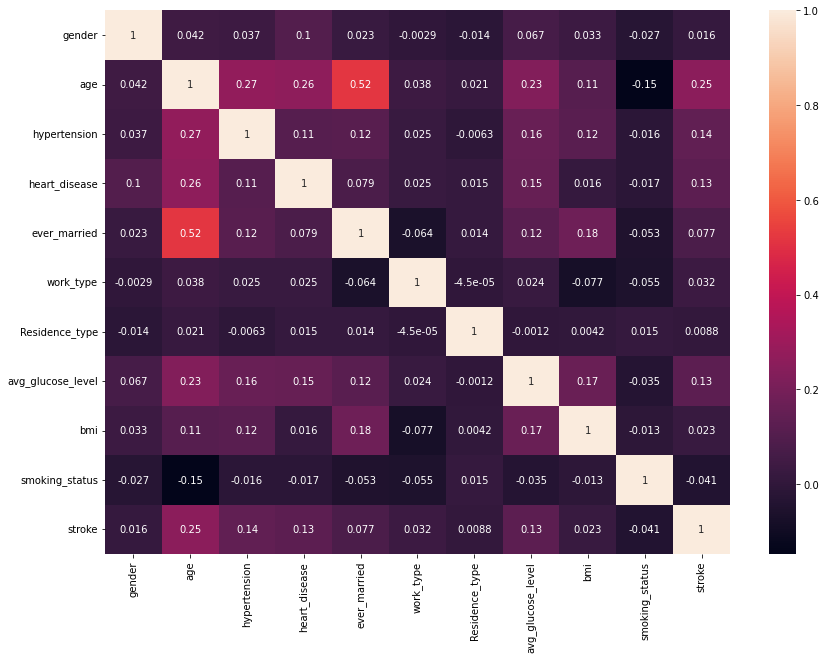

In [6]:
df = data_frame.copy()
df = eliminarDatosFaltantes(df)
df, _ = codDatosCategoricos(df)
corr_df = df.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr_df, annot=True)
plt.show()